In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_level_set(f, c, atol=1e-3):
    """
    Identify the points where the function values are approximately equal to c (level set).
    
    Args:
        f: The function values (array-like).
        c: The level value to compare against.
        atol: Absolute tolerance for comparing values with c.
        
    Returns:
        Indices where f is approximately equal to c within the given tolerance.
    """
    return np.where(np.isclose(f, c, atol=atol))

def identify_critical_points(f, x):
    """
    Identify the critical points by checking where the gradient of the function is approximately zero.
    
    Args:
        f: The function values (array-like).
        x: The corresponding x-values (array-like) for the function.
        
    Returns:
        Indices of the critical points where the gradient is close to zero.
    """
    # Use np.gradient to compute the numerical gradient of f with respect to x
    gradient = np.gradient(f, x)
    # Use compute_level_set to find where the gradient is close to zero (critical points)
    return compute_level_set(gradient, 0)

def construct_reeb_graph(f, x):
    """
    Construct a simple Reeb graph by connecting critical points. 
    
    Args:
        f: The function values (array-like).
        x: The corresponding x-values (array-like) for the function.
        
    Returns:
        A dictionary with vertices and edges representing the Reeb graph. 
        - 'vertices': List of tuples (x, f(x)) for critical points.
        - 'edges': List of tuples connecting consecutive critical points (as edges).
    """
    # Find the critical points
    critical_points = identify_critical_points(f, x)
    
    # Construct vertices as the (x, f(x)) pairs for the critical points
    vertices = [(x[i], f[i]) for i in critical_points[0]]  # critical_points is a tuple from np.where()
    
    # Construct edges by connecting consecutive critical points
    edges = [(vertices[i], vertices[i+1]) for i in range(len(vertices) - 1)]
    
    return {'vertices': vertices, 'edges': edges}

def anomaly_detection_reeb_graph(f, x):
    """
    Perform anomaly detection by examining vertices in the Reeb graph and flagging
    anomalous points based on some condition.
    
    Args:
        f: The function values (array-like).
        x: The corresponding x-values (array-like) for the function.
        
    Returns:
        A list of vertices that are classified as anomalies based on the is_anomalous function.
    """
    # Construct the Reeb graph first
    reeb_graph = construct_reeb_graph(f, x)
    
    # Initialize an empty list to store detected anomalies
    anomalies = []
    
    # Check each vertex in the Reeb graph to see if it is anomalous
    for vertex in reeb_graph['vertices']:
        if is_anomalous(vertex):
            anomalies.append(vertex)
    
    return anomalies

def is_anomalous(vertex):
    """
    Example condition for classifying an anomaly. This function flags points with function
    values that are above 0.8 or below -0.8.
    
    Args:
        vertex: A tuple representing a point (x, f(x)).
        
    Returns:
        True if the vertex is considered anomalous, False otherwise.
    """
    return vertex[1] > 0.8 or vertex[1] < -0.8

In [3]:
# Generate data for the sine wave
x_data = np.linspace(0, 10 * np.pi, 100000)
f_data = np.sin(x_data)

# Identify level sets and critical points
level_set = compute_level_set(f_data, 0)
critical_points = identify_critical_points(f_data, x_data)

# Construct the Reeb graph and detect anomalies
reeb_graph = construct_reeb_graph(f_data, x_data)
anomalies = anomaly_detection_reeb_graph(f_data, x_data)

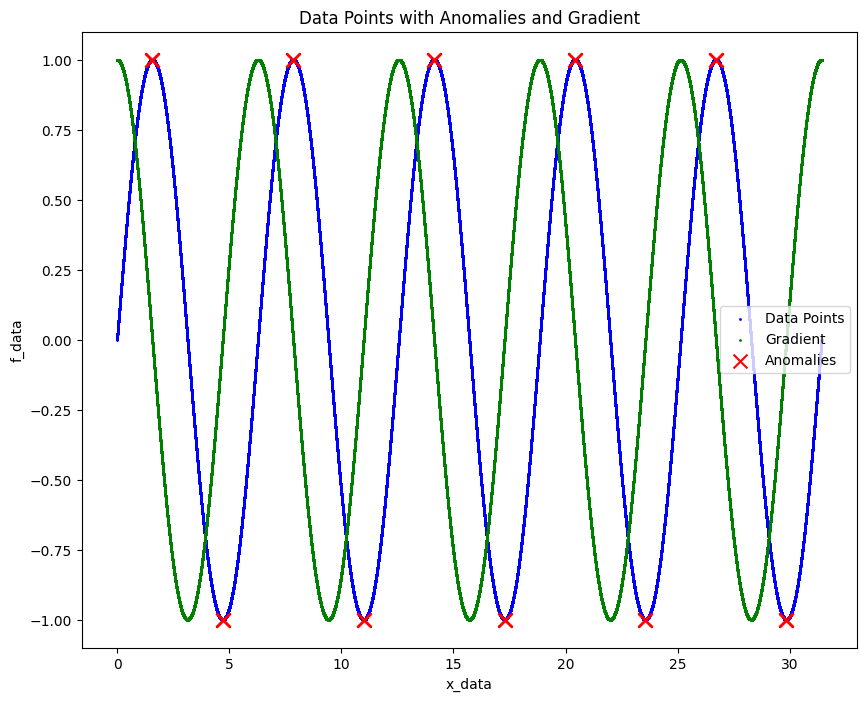

In [4]:
# Plotting
plt.figure(figsize=(10, 8))

# Plot the original data
plt.scatter(x_data, f_data, label='Data Points', color='blue', s=1)

# Plot the gradient of the function for reference
plt.scatter(x_data, np.gradient(f_data, x_data), label='Gradient', color='green', s=1)

# Separate the anomalies into x and y components for plotting
if anomalies:
    anomalies_x, anomalies_y = zip(*anomalies)
    plt.scatter(anomalies_x, anomalies_y, label='Anomalies', color='red', marker='x', s=100)

# Add labels and a legend
plt.xlabel('x_data')
plt.ylabel('f_data')
plt.title('Data Points with Anomalies and Gradient')
plt.legend()

# Show the plot
plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

def morse_function_example(x):
    """
    Example of a Morse function in 2D.
    This function is: f(x, y) = x^3 - 3xy^2
    Args:
        x: A list or array where x[0] is the x-coordinate and x[1] is the y-coordinate.
    Returns:
        The function value at the given point.
    """
    return x[0]**3 - 3 * x[0] * x[1]**2

def compute_gradient_at_point(f, x):
    """
    Compute the numerical gradient of a scalar function f at a given point x.
    Uses finite differences for approximation.
    
    Args:
        f: The function whose gradient needs to be computed.
        x: A point (array-like) where the gradient is evaluated.
        
    Returns:
        grad: The gradient vector (array) at the given point.
    """
    epsilon = np.sqrt(np.finfo(float).eps)  # Small perturbation for finite differences
    grad = np.zeros_like(x)  # Initialize the gradient vector
    
    # Loop over each variable (dimension) to compute partial derivatives
    for i in range(len(x)):
        x_step = x.copy()
        x_step[i] += epsilon  # Perturb only the i-th variable
        grad[i] = (f(x_step) - f(x)) / epsilon  # Approximate partial derivative
        
    return grad

def compute_gradient_on_grid(f, *grid_points):
    """
    Compute the gradient of a function f on a grid of points in n dimensions.
    It calculates the gradient at each point of the meshgrid.
    
    Args:
        f: The function whose gradient needs to be computed.
        grid_points: The grid points along each dimension (arrays like x, y, z, etc.).
        
    Returns:
        grad_components: A list of arrays where each array corresponds to the partial
                         derivatives with respect to each variable.
    """
    # Create a meshgrid from the input grid points (handles arbitrary dimensions)
    mesh = np.meshgrid(*grid_points, indexing='ij')
    mesh_shape = mesh[0].shape  # Shape of the grid (same for all dimensions)
    
    # Initialize a list to store the gradient components for each variable
    grad_components = [np.zeros(mesh_shape) for _ in range(len(grid_points))]
    
    # Iterate over all points in the n-dimensional grid using multi-indexing
    it = np.nditer(mesh[0], flags=['multi_index'])
    while not it.finished:
        # Extract the point in n-dimensions (e.g., [x, y, z] for 3D)
        point = np.array([m[it.multi_index] for m in mesh])
        grad = compute_gradient_at_point(f, point)  # Compute gradient at the current point
        
        # Assign the computed gradient components to the respective arrays
        for i in range(len(grid_points)):
            grad_components[i][it.multi_index] = grad[i]
        
        it.iternext()

    return grad_components

def find_critical_points(*grad_components, tolerance=1e-3):
    """
    Identify critical points where the gradient is approximately zero.
    
    Args:
        grad_components: The list of gradient components (one for each variable).
        tolerance: The numerical tolerance to determine if the gradient is "zero".
        
    Returns:
        is_critical_point: A boolean array where True indicates a critical point.
    """
    # Initialize an array of True values (same shape as the gradient components)
    is_critical_point = np.ones_like(grad_components[0], dtype=bool)
    
    # Check if each gradient component is close to zero for all variables
    for grad in grad_components:
        is_critical_point &= np.abs(grad) < tolerance  # Logical AND for all components

    return is_critical_point

def compute_hessian(f, x):
    """
    Compute the Hessian matrix (second-order partial derivatives) of function f at point x.
    
    Args:
        f: The function whose Hessian is to be computed.
        x: A point (array-like) where the Hessian is evaluated.
        
    Returns:
        hessian: The Hessian matrix at the given point.
    """
    x = np.asarray(x, dtype=float)  # Ensure x is an array
    hessian = np.zeros((len(x), len(x)))  # Initialize Hessian matrix
    epsilon = np.sqrt(np.finfo(float).eps)  # Small perturbation for finite differences
    
    # Loop over each combination of variables (i, j) to compute second-order partial derivatives
    for i in range(len(x)):
        for j in range(i, len(x)):  # Only compute upper triangle (Hessian is symmetric)
            
            # Define a function to perturb the variables by epsilon
            def shift_epsilon(e_i, e_j):
                x_new = x.copy()
                x_new[i] += e_i  # Perturb i-th variable
                x_new[j] += e_j  # Perturb j-th variable
                return f(x_new)
            
            # Compute second-order partial derivatives using central differences
            hessian[i, j] = (shift_epsilon(epsilon, epsilon) 
                            - shift_epsilon(epsilon, 0) 
                            - shift_epsilon(0, epsilon) 
                            + shift_epsilon(0, 0)) / (epsilon ** 2)
            
            # Copy the value to the lower triangular part (Hessian is symmetric)
            if i != j:
                hessian[j, i] = hessian[i, j]
    
    return hessian

def is_morse(f, x):
    """
    Check if a critical point is a Morse point by inspecting the Hessian matrix.
    
    Args:
        f: The function whose critical point is being checked.
        x: A critical point (array-like).
        
    Returns:
        True if the point is a Morse point (Hessian has no zero eigenvalues), False otherwise.
    """
    hessian = compute_hessian(f, x)
    try:
        # Compute the eigenvalues of the Hessian matrix
        eigvals = eigh(hessian, eigvals_only=True)
        return np.all(eigvals != 0)  # Return True if all eigenvalues are non-zero
    except np.linalg.LinAlgError:
        return False  # If Hessian computation fails, it's not a Morse point

In [6]:
# Define a grid for 2D case as an example (but this will work for more variables)
x = np.linspace(-5, 5, 1000)
y = np.linspace(-5, 5, 1000)

# Generalize to n-dimensional input, here it's 2D
X, Y = np.meshgrid(x, y, indexing='ij')

# Compute the function values on the grid
Z = morse_function_example([X, Y])

# Compute the gradient on the grid (generalized for n dimensions)
grad_components = compute_gradient_on_grid(morse_function_example, x, y)

# Find critical points where the gradient is approximately zero
critical_points = find_critical_points(*grad_components, tolerance=1e-3)

# Identify which of the critical points are Morse points
morse_points = np.zeros_like(critical_points, dtype=bool)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        if critical_points[i, j]:
            point = [X[i, j], Y[i, j]]
            if is_morse(morse_function_example, point):
                morse_points[i, j] = True

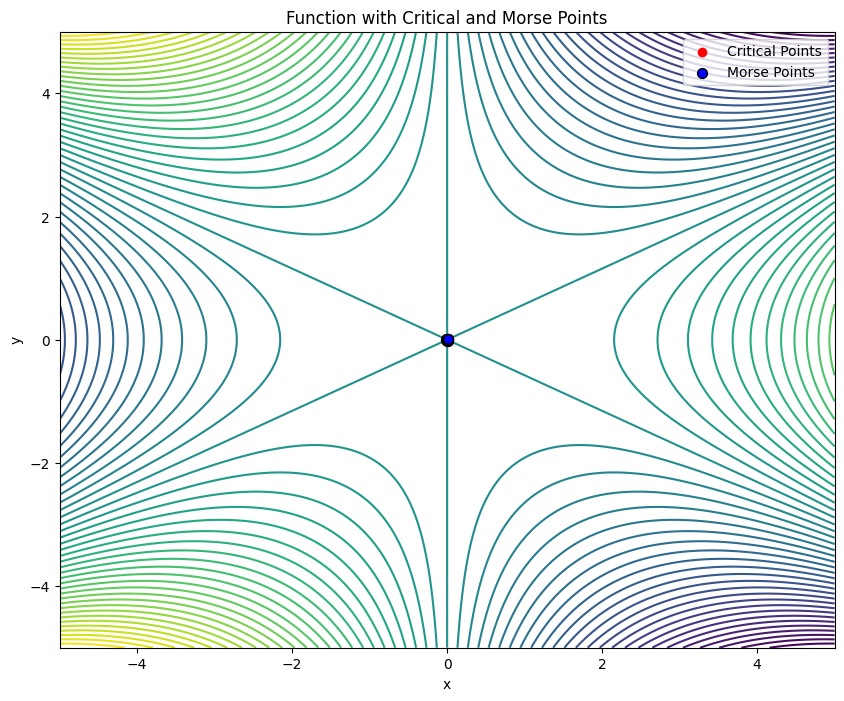

In [7]:
plt.figure(figsize=(10, 8))
plt.contour(X, Y, Z, levels=50, cmap='viridis')
plt.scatter(X[critical_points], Y[critical_points], color='red', label="Critical Points", zorder=5)
# Highlight Morse points in blue with black edges
plt.scatter(X[morse_points], Y[morse_points], color='blue', edgecolor='black', s=50, label="Morse Points", zorder=6)
# Add titles and labels
plt.title("Function with Critical and Morse Points")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()